# Klasyfikator SVM

In [13]:
import numpy as np
from scipy.optimize import Bounds, minimize
from sklearn import svm
import math
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, RocCurveDisplay, auc, balanced_accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

### Generowanie zbiorów danych

Generowanie zbioru make_classification

In [14]:
x1, y1 = make_classification(random_state=254448, n_samples=2548, n_features=2, n_redundant=0, n_informative=2)
y1[y1==0] = -1

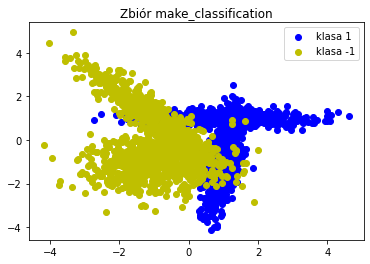

In [15]:
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], c='b', label='klasa 1')
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], c='y', label='klasa -1')
plt.legend()
plt.title('Zbiór make_classification')
plt.show()

Generowanie zbioru make_moons

In [16]:
x2, y2 = make_moons(n_samples=2548, random_state=254448, shuffle=True)
y2[y2==0] = -1

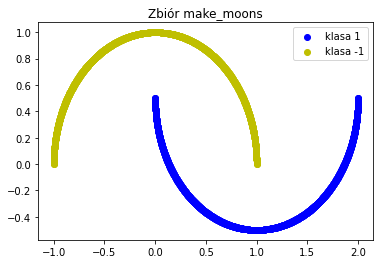

In [17]:
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], c='b', label='klasa 1')
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], c='y', label='klasa -1')
plt.legend()
plt.title('Zbiór make_moons')
plt.show()

## Implementacja SVM

In [131]:
class SVMImplementation():
    def fit(self, x, y, kernel='linear', gamma=0, c=0, d=0):
        self.train_x = x
        self.train_y = y
        initial_lambda = np.ones(len(x))
        lambda_bounds = Bounds(np.zeros_like(initial_lambda), np.ones_like(initial_lambda))
        self.gamma = gamma
        self.c = c
        self.d = d
        self.kernel= kernel
        
        if kernel=='linear':
            res = minimize(SVMImplementation.objective_function_linear, initial_lambda, args=(x, y), bounds=lambda_bounds, method='Powell')
            w = sum([res.x[i]*x[i]*y[i] for i in range(len(x))])
            
            support_vectors = x[res.x > 1e-4]
            support_lab = y[res.x > 1e-4]
            lagrange_coef = res.x[res.x > 1e-4]
            
            b = np.mean(support_lab-np.dot((lagrange_coef *support_lab), (support_vectors @ support_vectors.T)))
            self.b = b
            self.lam = res.x
        elif kernel=='radial':
            res = minimize(SVMImplementation.objective_function_radial, initial_lambda, args=(x, y, gamma), bounds=lambda_bounds, method='Powell')
            w = 0
            
            support_vectors = x[res.x > 1e-4]
            support_lab = y[res.x > 1e-4]
            lagrange_coef = res.x[res.x > 1e-4]
            
            b = np.mean(support_lab-np.dot((lagrange_coef * support_lab), math.exp(-gamma*np.sum(np.abs(support_vectors - support_vectors) ** 2))))
            self.b = b
            
            self.lam = res.x
        elif kernel=='polynomial':
            res = minimize(SVMImplementation.objective_function_polynomial, initial_lambda, args=(x, y, c, d), bounds=lambda_bounds, method='Powell')
            self.lam = res.x
            w = 0

            support_vectors = x[res.x > 1e-4]
            support_lab = y[res.x > 1e-4]
            lagrange_coef = res.x[res.x > 1e-4]

            b = np.mean(support_lab-np.dot((lagrange_coef * support_lab), (support_vectors @ support_vectors.T +self.c)**self.d))
            self.b = b
            
        self.w = w
        return [w, b]
    
    def objective_function_linear(lam, x, y):
        return -sum(lam) + 0.5*sum([lam[i]*lam[j]*y[i]*y[j]*np.dot(x[i],x[j]) for i in range(len(x)) for j in range(len(x))])
    
    def objective_function_radial(lam, x, y, gamma):
        return -sum(lam) + 0.5*sum(([lam[i]*lam[j]*y[i]*y[j]*math.exp(-gamma*np.sum(np.abs(x[i] - x[j]) ** 2)) for i in range(len(x)) for j in range(len(x))]))
    
    def objective_function_polynomial(lam, x, y, c, d):
        return -sum(lam) + 0.5*sum(([lam[i]*lam[j]*y[i]*y[j]*(np.dot(x[i],x[j])+c)**d for i in range(len(x)) for j in range(len(x))]))
    
    
    def predict(self, x):
        results = []
        if self.kernel == 'linear':
            for sample in x:
                results.append(1 if np.dot(sample, self.w)+self.b>0 else -1)
        elif self.kernel == 'radial':
            for sample in x:
                wyn = sum(self.lam[i]*self.train_y[i]*math.exp(-self.gamma*np.sum(np.abs(self.train_x[i] - sample) ** 2))+self.b for i in range(len(self.train_x)))
                results.append(1 if wyn>0 else -1)
        elif self.kernel == 'polynomial':
            for sample in x:
                wyn = sum(self.lam[i]*self.train_y[i]*(np.dot(sample, self.train_x[i])+self.c)**self.d for i in range(len(self.train_x)))+self.b
                results.append(1 if wyn>0 else -1)
        return results
    
    def predict_values(self, x):
        results = []
        if self.kernel == 'linear':
            for sample in x:
                results.append(np.dot(sample, self.w)+self.b)
        elif self.kernel == 'radial':
            for sample in x:
                wyn = sum(self.lam[i]*self.train_y[i]*math.exp(-self.gamma*np.sum(np.abs(self.train_x[i] - sample) ** 2))+self.b for i in range(len(self.train_x)))
                results.append(wyn)
        elif self.kernel == 'polynomial':
            for sample in x:
                wyn = sum(self.lam[i]*self.train_y[i]*(np.dot(sample, self.train_x[i])+self.c)**self.d+self.b for i in range(len(self.train_x)))
                results.append(wyn>0)
        return results

## Porównanie implementacji dla linear kernel

### Porównanie na zbiorze make_classification

Własna implementacja

In [19]:
linearsvm_c = SVMImplementation()
linearsvm_c.fit(x1[:50], y1[:50])

[array([1.49479438, 0.41578847]), -0.24712734287931265]

In [20]:
pred_linear_c = linearsvm_c.predict(x1[50:100])
accuracy_score(y1[50:100], pred_linear_c)

0.86

Implementacja z sklearn

In [21]:
svm_sklearn_c = svm.SVC(kernel='linear')
svm_sklearn_c.fit(x1[:50], y1[:50])
pred_sklearn_c = svm_sklearn_c.predict(x1[50:100])
accuracy_score(y1[50:100], pred_sklearn_c)

0.88

Macierz pomyłek dla własnej implementacji


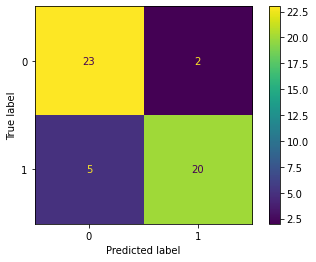

In [22]:
print('Macierz pomyłek dla własnej implementacji')
cm_linear_c = confusion_matrix(y1[50:100], pred_linear_c, labels=[-1,1])
disp_linear_c = ConfusionMatrixDisplay(confusion_matrix=cm_linear_c)
disp_linear_c.plot()
plt.show()

Macierz pomyłek dla implementacji z sklearn


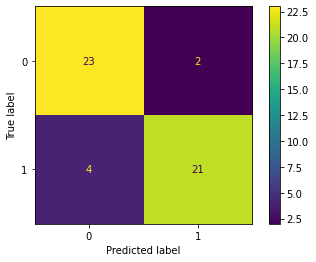

In [23]:
print('Macierz pomyłek dla implementacji z sklearn')
cm_sklearn_c = confusion_matrix(y1[50:100], pred_sklearn_c, labels=[-1,1])
disp_sklearn_c = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_c)
disp_sklearn_c.plot()
plt.show()

In [24]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)

X, Y = np.meshgrid(x,y)
Z = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z.append(linearsvm_c.predict([[X[i,j], Y[i,j]]]))
           
Z = np.reshape(Z, X.shape)

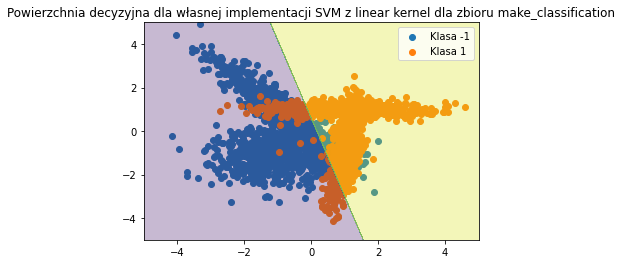

In [25]:
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], label='Klasa -1')
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla własnej implementacji SVM z linear kernel dla zbioru make_classification')
plt.show()

In [26]:
Z_linear = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_linear.append(svm_sklearn_c.predict([[X[i,j], Y[i,j]]]))
               
Z_linear = np.reshape(Z_linear, X.shape)

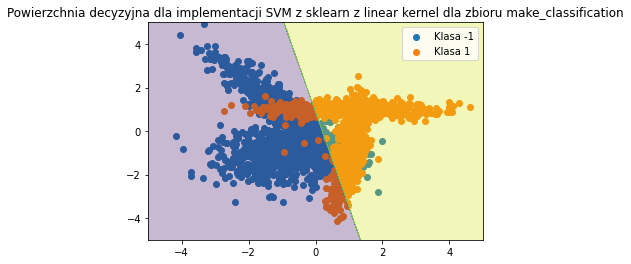

In [27]:
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], label='Klasa -1')
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_linear, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z linear kernel dla zbioru make_classification')
plt.show()

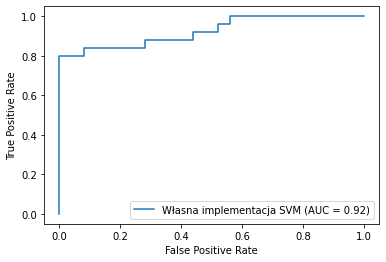

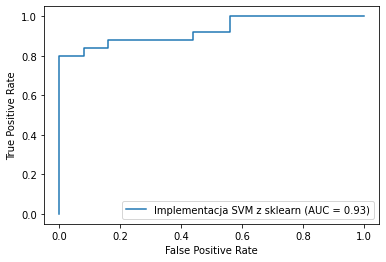

In [28]:
y_roc_i = linearsvm_c.predict_values(x1[50:100])
y_roc_s = svm_sklearn_c.decision_function(x1[50:100])

fpr_i, tpr_i, tresholds_i = roc_curve(y1[50:100], y_roc_i)
fpr_s, tpr_s, tresholds_s = roc_curve(y1[50:100], y_roc_s)
auc_i = auc(fpr_i, tpr_i)
auc_s = auc(fpr_s, tpr_s)

display_i = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i, roc_auc=auc_i, estimator_name='Własna implementacja SVM')
display_s = RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=auc_s, estimator_name='Implementacja SVM z sklearn')
display_i.plot()
display_s.plot()
plt.show()

In [29]:
print('Własna implementacja:')
print('accuracy', accuracy_score(y1[50:100], pred_linear_c))
print('sensitivity', recall_score(y1[50:100], pred_linear_c))
#0,0 / 0,0 + 0,1
print('specificity', cm_linear_c[0][0]/(cm_linear_c[0][0]+cm_linear_c[0][1]))
print()
print('Sklearn:')
print('accuracy', accuracy_score(y1[50:100], pred_sklearn_c))
print('sensitivity', recall_score(y1[50:100], pred_sklearn_c))
#0,0 / 0,0 + 0,1
print('specificity', cm_sklearn_c[0][0]/(cm_sklearn_c[0][0]+cm_sklearn_c[0][1]))

Własna implementacja:
accuracy 0.86
sensitivity 0.8
specificity 0.92

Sklearn:
accuracy 0.88
sensitivity 0.84
specificity 0.92


Implementacja z sklearn radzi sobie lepiej na tym zbiorze.

### Porównanie na zbiorze make_moons

Własna implementacja

In [30]:
linearsvm_m = SVMImplementation()
linearsvm_m.fit(x2[:50], y2[:50])
pred_linear_m = linearsvm_m.predict(x2[50:100])

Macierz pomyłek dla własnej implementacji


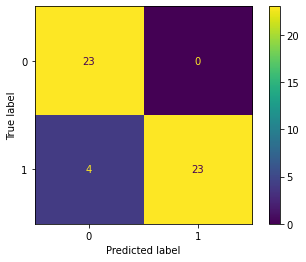

In [31]:
print('Macierz pomyłek dla własnej implementacji')
cm_linear_m = confusion_matrix(y2[50:100], pred_linear_m, labels=[-1,1])
disp_linear_m = ConfusionMatrixDisplay(confusion_matrix=cm_linear_m)
disp_linear_m.plot()
plt.show()

Implementacja z sklearn

In [32]:
svm_sklearn_m = svm.SVC(kernel='linear')
svm_sklearn_m.fit(x2[:50], y2[:50])
pred_sklearn_m = svm_sklearn_m.predict(x2[50:100])

Macierz pomyłek dla implementacji z sklearn


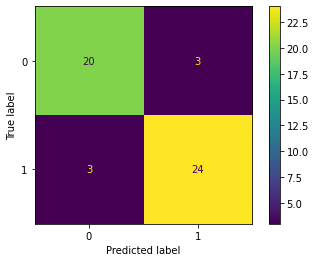

In [33]:
print('Macierz pomyłek dla implementacji z sklearn')
cm_sklearn_m = confusion_matrix(y2[50:100], pred_sklearn_m, labels=[-1,1])
disp_sklearn_m = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_m)
disp_sklearn_m.plot()
plt.show()

In [34]:
Z_m = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_m.append(linearsvm_m.predict([[X[i,j], Y[i,j]]]))
           
Z_m = np.reshape(Z_m, X.shape)

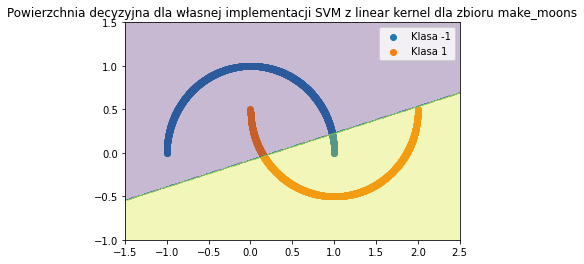

In [35]:
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], label='Klasa -1')
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_m, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla własnej implementacji SVM z linear kernel dla zbioru make_moons')
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.show()

In [36]:
Z_m_s = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_m_s.append(linearsvm_m.predict([[X[i,j], Y[i,j]]]))
           
Z_m_s = np.reshape(Z_m_s, X.shape)

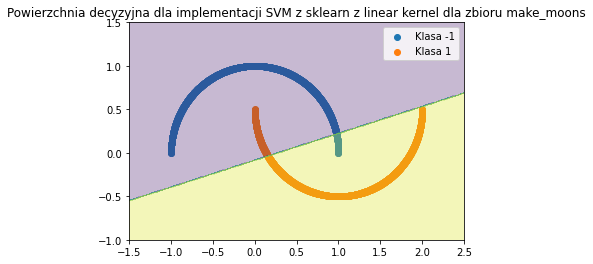

In [37]:
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], label='Klasa -1')
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_m_s, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z linear kernel dla zbioru make_moons')
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.show()

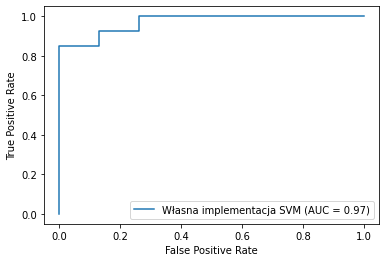

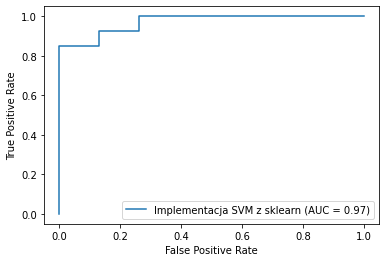

In [38]:
y_roc_i = linearsvm_m.predict_values(x2[50:100])
y_roc_s = svm_sklearn_m.decision_function(x2[50:100])

fpr_i, tpr_i, tresholds_i = roc_curve(y2[50:100], y_roc_i)
fpr_s, tpr_s, tresholds_s = roc_curve(y2[50:100], y_roc_s)
auc_i = auc(fpr_i, tpr_i)
auc_s = auc(fpr_s, tpr_s)

display_i = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i, roc_auc=auc_i, estimator_name='Własna implementacja SVM')
display_s = RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=auc_s, estimator_name='Implementacja SVM z sklearn')
display_i.plot()
display_s.plot()
plt.show()

In [39]:
print('Własna implementacja:')
print('accuracy', accuracy_score(y2[50:100], pred_linear_m))
print('sensitivity', recall_score(y2[50:100], pred_linear_m))
#0,0 / 0,0 + 0,1
print('specificity', cm_linear_m[0][0]/(cm_linear_m[0][0]+cm_linear_m[0][1]))
print()
print('Sklearn:')
print('accuracy', accuracy_score(y2[50:100], pred_sklearn_m))
print('sensitivity', recall_score(y2[50:100], pred_sklearn_m))
#0,0 / 0,0 + 0,1
print('specificity', cm_sklearn_m[0][0]/(cm_sklearn_m[0][0]+cm_sklearn_m[0][1]))

Własna implementacja:
accuracy 0.92
sensitivity 0.8518518518518519
specificity 1.0

Sklearn:
accuracy 0.88
sensitivity 0.8888888888888888
specificity 0.8695652173913043


Lepsze wyniki uzyskała implementacja z sklearn.

## Porównanie SVM z radial kernel

### Porównanie na zbiorze make_classification

Własna implementacja

In [40]:
radial_svm_c = SVMImplementation()
radial_svm_c.fit(x1[:50], y1[:50], kernel='radial', gamma=0.5)

[0, -0.0044039555932703445]

In [41]:
pred_radial_c = radial_svm_c.predict(x1[50:100])

Macierz pomyłek dla własnej implementacji


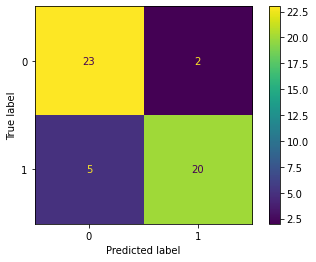

In [42]:
print('Macierz pomyłek dla własnej implementacji')
cm_radial_c = confusion_matrix(y1[50:100], pred_radial_c, labels=[-1,1])
disp_radial_c = ConfusionMatrixDisplay(confusion_matrix=cm_radial_c)
disp_radial_c.plot()
plt.show()

Implementacja z sklearn

In [43]:
radial_sklearn_c = svm.SVC(kernel='rbf', gamma='auto')
radial_sklearn_c.fit(x1[:50], y1[:50])
pred_rad_sk_c = radial_sklearn_c.predict(x1[50:100])

Macierz pomyłek dla implementacji z sklearn


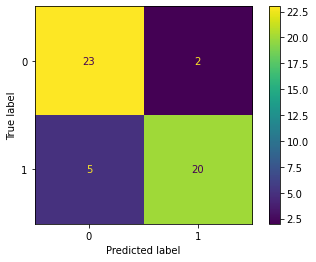

In [44]:
print('Macierz pomyłek dla implementacji z sklearn')
cm_radial_sk_c = confusion_matrix(y1[50:100], pred_rad_sk_c, labels=[-1,1])
disp_radial_sk_c = ConfusionMatrixDisplay(confusion_matrix=cm_radial_sk_c)
disp_radial_sk_c.plot()
plt.show()

In [45]:
Z_rad_c = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_rad_c.append(radial_svm_c.predict([[X[i,j], Y[i,j]]]))
           
Z_rad_c = np.reshape(Z_rad_c, X.shape)

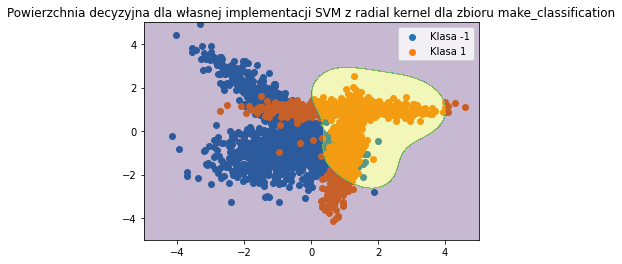

In [46]:
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], label='Klasa -1')
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_rad_c, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla własnej implementacji SVM z radial kernel dla zbioru make_classification')
plt.show()

In [47]:
Z_rad_sk_c = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_rad_sk_c.append(radial_sklearn_c.predict([[X[i,j], Y[i,j]]]))
           
Z_rad_sk_c = np.reshape(Z_rad_sk_c, X.shape)

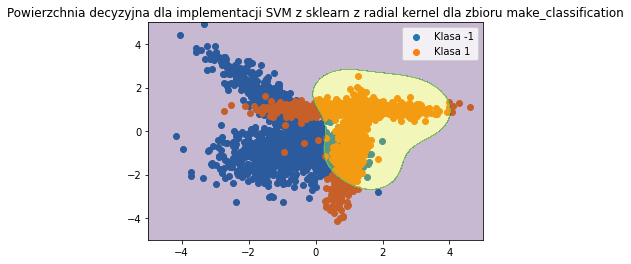

In [48]:
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], label='Klasa -1')
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_rad_sk_c, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z radial kernel dla zbioru make_classification')
plt.show()

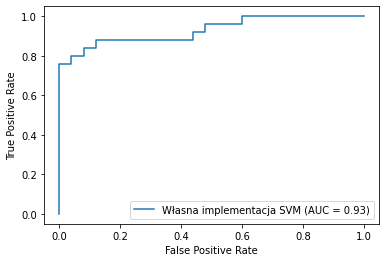

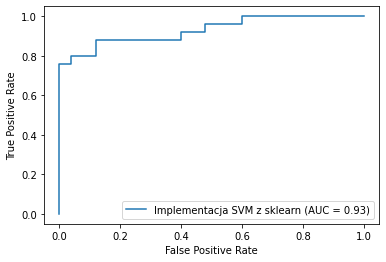

In [49]:
y_roc_i = radial_svm_c.predict_values(x1[50:100])
y_roc_s = radial_sklearn_c.decision_function(x1[50:100])

fpr_i, tpr_i, tresholds_i = roc_curve(y1[50:100], y_roc_i)
fpr_s, tpr_s, tresholds_s = roc_curve(y1[50:100], y_roc_s)
auc_i = auc(fpr_i, tpr_i)
auc_s = auc(fpr_s, tpr_s)

display_i = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i, roc_auc=auc_i, estimator_name='Własna implementacja SVM')
display_s = RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=auc_s, estimator_name='Implementacja SVM z sklearn')
display_i.plot()
display_s.plot()
plt.show()

In [50]:
print('Własna implementacja:')
print('accuracy', accuracy_score(y1[50:100], pred_radial_c))
print('sensitivity', recall_score(y1[50:100], pred_radial_c))
#0,0 / 0,0 + 0,1
print('specificity', cm_radial_c[0][0]/(cm_radial_c[0][0]+cm_radial_c[0][1]))
print()
print('Sklearn:')
print('accuracy', accuracy_score(y1[50:100], pred_rad_sk_c))
print('sensitivity', recall_score(y1[50:100], pred_rad_sk_c))
#0,0 / 0,0 + 0,1
print('specificity', cm_radial_sk_c[0][0]/(cm_radial_sk_c[0][0]+cm_radial_sk_c[0][1]))

Własna implementacja:
accuracy 0.86
sensitivity 0.8
specificity 0.92

Sklearn:
accuracy 0.86
sensitivity 0.8
specificity 0.92


Obie implementacje uzyskały takie same wyniki.

### Porównanie na zbiorze make_moons

Własna implementacja

In [140]:
radial_svm_m = SVMImplementation()
radial_svm_m.fit(x2[:50], y2[:50], kernel='radial', gamma=0.1)

In [141]:
pred_radial_m = radial_svm_m.predict(x2[50:100])

Macierz pomyłek dla własnej implementacji


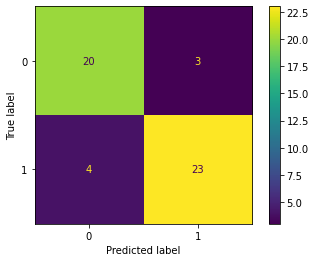

In [142]:
print('Macierz pomyłek dla własnej implementacji')
cm_radial_m = confusion_matrix(y2[50:100], pred_radial_m, labels=[-1,1])
disp_radial_m = ConfusionMatrixDisplay(confusion_matrix=cm_radial_m)
disp_radial_m.plot()
plt.show()

Implementacja z sklearn

In [143]:
svm_radial_sk_m = svm.SVC(kernel='rbf')
svm_radial_sk_m.fit(x2[:50], y2[:50])
pred_sklearn_m = svm_radial_sk_m.predict(x2[50:100])

Macierz pomyłek dla implementacji z sklearn


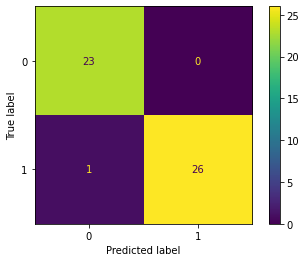

In [144]:
print('Macierz pomyłek dla implementacji z sklearn')
cm_radial_sk_m = confusion_matrix(y2[50:100], pred_sklearn_m, labels=[-1,1])
disp_radial_sk_m = ConfusionMatrixDisplay(confusion_matrix=cm_radial_sk_m)
disp_radial_sk_m.plot()
plt.show()

In [145]:
Z_radial_m = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_radial_m.append(radial_svm_m.predict([[X[i,j], Y[i,j]]]))
           
Z_radial_m = np.reshape(Z_radial_m, X.shape)

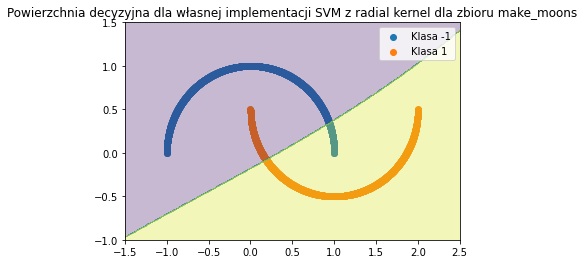

In [146]:
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], label='Klasa -1')
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_radial_m, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla własnej implementacji SVM z radial kernel dla zbioru make_moons')
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.show()

In [71]:
Z_radial_m_s = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_radial_m_s.append(svm_radial_sk_m.predict([[X[i,j], Y[i,j]]]))
           
Z_radial_m_s = np.reshape(Z_radial_m_s, X.shape)

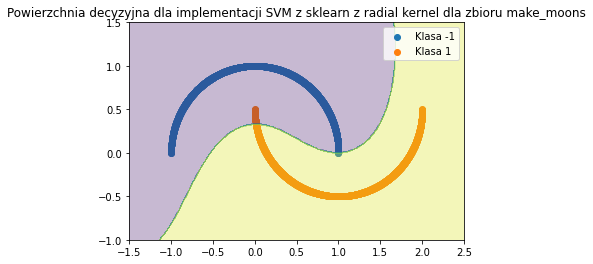

In [72]:
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], label='Klasa -1')
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_radial_m_s, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z radial kernel dla zbioru make_moons')
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.show()

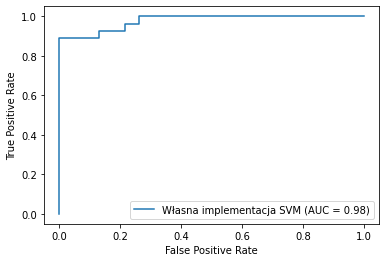

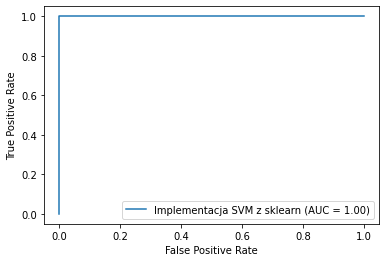

In [73]:
y_roc_i = radial_svm_m.predict_values(x2[50:100])
y_roc_s = svm_radial_sk_m.decision_function(x2[50:100])

fpr_i, tpr_i, tresholds_i = roc_curve(y2[50:100], y_roc_i)
fpr_s, tpr_s, tresholds_s = roc_curve(y2[50:100], y_roc_s)
auc_i = auc(fpr_i, tpr_i)
auc_s = auc(fpr_s, tpr_s)

display_i = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i, roc_auc=auc_i, estimator_name='Własna implementacja SVM')
display_s = RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=auc_s, estimator_name='Implementacja SVM z sklearn')
display_i.plot()
display_s.plot()
plt.show()

In [74]:
print('Własna implementacja:')
print('accuracy', accuracy_score(y2[50:100], pred_radial_m))
print('sensitivity', recall_score(y2[50:100], pred_radial_m))
#0,0 / 0,0 + 0,1
print('specificity', cm_radial_m[0][0]/(cm_radial_m[0][0]+cm_radial_m[0][1]))
print()
print('Sklearn:')
print('accuracy', accuracy_score(y2[50:100], pred_sklearn_m))
print('sensitivity', recall_score(y2[50:100], pred_sklearn_m))
#0,0 / 0,0 + 0,1
print('specificity', cm_radial_sk_m[0][0]/(cm_radial_sk_m[0][0]+cm_radial_sk_m[0][1]))

Własna implementacja:
accuracy 0.46
sensitivity 0.0
specificity 1.0

Sklearn:
accuracy 0.98
sensitivity 0.9629629629629629
specificity 1.0


Implementacja z sklearn uzyskała lepsze wyniki.

## Porównanie SVM z polynomial kernel

### Porównanie na zbiorze make_classification

Własna implementacja

In [132]:
svm_polynomial_i = SVMImplementation()
svm_polynomial_i.fit(x1[:50], y1[:50], kernel='polynomial', c=4, d=3)
svm_polynomial_i.w

0

In [133]:
polynomial_predict = svm_polynomial_i.predict(x1[50:100])

Macierz pomyłek dla własnej implementacji


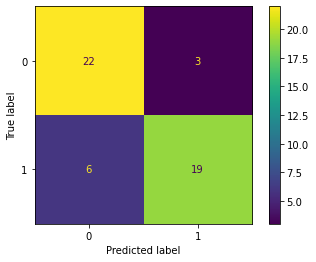

In [134]:
print('Macierz pomyłek dla własnej implementacji')
cm_poly_c = confusion_matrix(y1[50:100], polynomial_predict, labels=[-1,1])
disp_poly_c = ConfusionMatrixDisplay(confusion_matrix=cm_poly_c)
disp_poly_c.plot()
plt.show()

Implementacja z sklearn

In [135]:
svm_poly_sk_c = svm.SVC(kernel='poly', degree=3)
svm_poly_sk_c.fit(x1[:50], y1[:50])
pred_poly_sk_c = svm_poly_sk_c.predict(x1[50:100])
accuracy_score(y1[50:100], pred_poly_sk_c)

0.7

Macierz pomyłek dla implementacji z sklearn


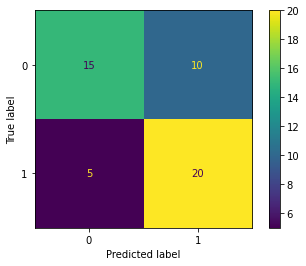

In [136]:
print('Macierz pomyłek dla implementacji z sklearn')
cm_poly_sk_c = confusion_matrix(y1[50:100], pred_poly_sk_c, labels=[-1,1])
disp_poly_sk_c = ConfusionMatrixDisplay(confusion_matrix=cm_poly_sk_c)
disp_poly_sk_c.plot()
plt.show()

In [137]:
Z_polynomial_i = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_polynomial_i.append(svm_polynomial_i.predict([[X[i,j], Y[i,j]]]))
           
Z_polynomial_i = np.reshape(Z_polynomial_i, X.shape)

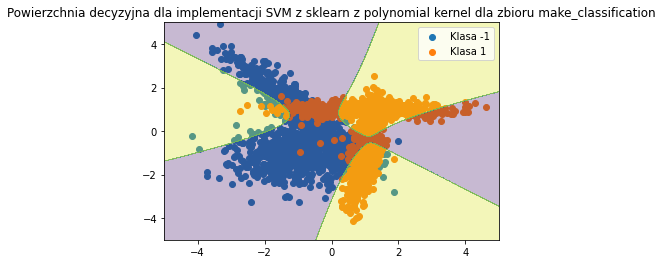

In [138]:
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], label='Klasa -1')
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_polynomial_i, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z polynomial kernel dla zbioru make_classification')
plt.show()

In [90]:
Z_poly_sk = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_poly_sk.append(svm_poly_sk_c.predict([[X[i,j], Y[i,j]]]))
               
Z_poly_sk = np.reshape(Z_poly_sk, X.shape)

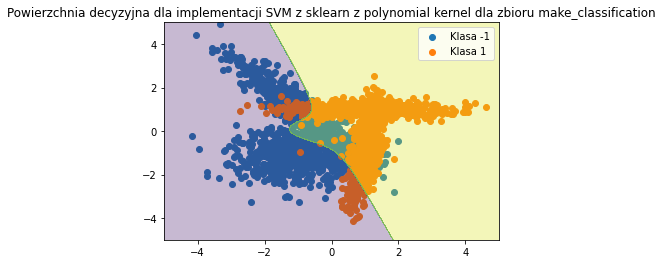

In [91]:
plt.scatter(x1[:,0][y1==-1], x1[:,1][y1==-1], label='Klasa -1')
plt.scatter(x1[:,0][y1==1], x1[:,1][y1==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_poly_sk, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z polynomial kernel dla zbioru make_classification')
plt.show()

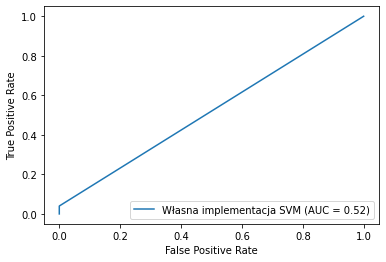

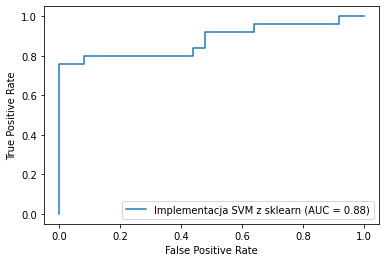

In [92]:
y_roc_i = svm_polynomial_i.predict_values(x1[50:100])
y_roc_s = svm_poly_sk_c.decision_function(x1[50:100])

fpr_i, tpr_i, tresholds_i = roc_curve(y1[50:100], y_roc_i)
fpr_s, tpr_s, tresholds_s = roc_curve(y1[50:100], y_roc_s)
auc_i = auc(fpr_i, tpr_i)
auc_s = auc(fpr_s, tpr_s)

display_i = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i, roc_auc=auc_i, estimator_name='Własna implementacja SVM')
display_s = RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=auc_s, estimator_name='Implementacja SVM z sklearn')
display_i.plot()
display_s.plot()
plt.show()

In [93]:
print('Własna implementacja:')
print('accuracy', accuracy_score(y1[50:100], polynomial_predict))
print('sensitivity', recall_score(y1[50:100], polynomial_predict))
print('specificity', cm_poly_c[0][0]/(cm_poly_c[0][0]+cm_poly_c[0][1]))
print()
print('Sklearn:')
print('accuracy', accuracy_score(y1[50:100], pred_poly_sk_c))
print('sensitivity', recall_score(y1[50:100], pred_poly_sk_c))
print('specificity', cm_poly_sk_c[0][0]/(cm_poly_sk_c[0][0]+cm_poly_sk_c[0][1]))

Własna implementacja:
accuracy 0.82
sensitivity 0.76
specificity 0.88

Sklearn:
accuracy 0.7
sensitivity 0.8
specificity 0.6


Własna implementacja uzyskała lepsze wyniki na zbiorze.

### Porównanie na zbiorze make_moons

Własna implementacja

In [94]:
poly_svm_m = SVMImplementation()
poly_svm_m.fit(x2[:50], y2[:50], kernel='polynomial', c=4, d=3)

[0, -3.0035166408624843]

In [95]:
pred_poly_m = poly_svm_m.predict(x2[50:100])

Macierz pomyłek dla własnej implementacji


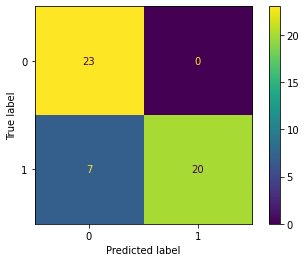

In [96]:
print('Macierz pomyłek dla własnej implementacji')
cm_poly_m = confusion_matrix(y2[50:100], pred_poly_m, labels=[-1,1])
disp_poly_m = ConfusionMatrixDisplay(confusion_matrix=cm_poly_m)
disp_poly_m.plot()
plt.show()

Implementacja z sklearn

In [97]:
svm_poly_sk_m = svm.SVC(kernel='poly')
svm_poly_sk_m.fit(x2[:50], y2[:50])
pred_poly_sk_m = svm_poly_sk_m.predict(x2[50:100])

Macierz pomyłek dla implementacji z sklearn


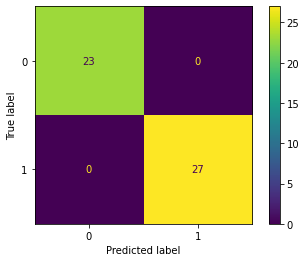

In [98]:
print('Macierz pomyłek dla implementacji z sklearn')
cm_poly_sk_m = confusion_matrix(y2[50:100], pred_poly_sk_m, labels=[-1,1])
disp_poly_sk_m = ConfusionMatrixDisplay(confusion_matrix=cm_poly_sk_m)
disp_poly_sk_m.plot()
plt.show()

In [99]:
Z_poly_m = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_poly_m.append(poly_svm_m.predict([[X[i,j], Y[i,j]]]))
           
Z_poly_m = np.reshape(Z_poly_m, X.shape)

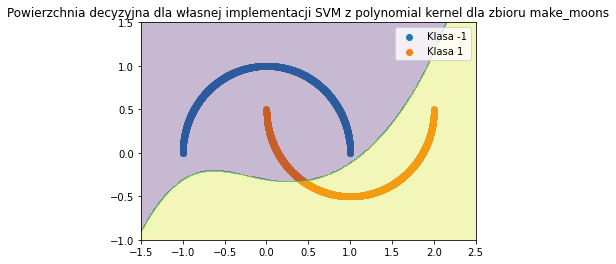

In [100]:
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], label='Klasa -1')
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_poly_m, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla własnej implementacji SVM z polynomial kernel dla zbioru make_moons')
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.show()

In [101]:
Z_poly_m_s = []

for i in range(len(X)):
    for j in range(len(Y)):
        Z_poly_m_s.append(svm_poly_sk_m.predict([[X[i,j], Y[i,j]]]))
           
Z_poly_m_s = np.reshape(Z_poly_m_s, X.shape)

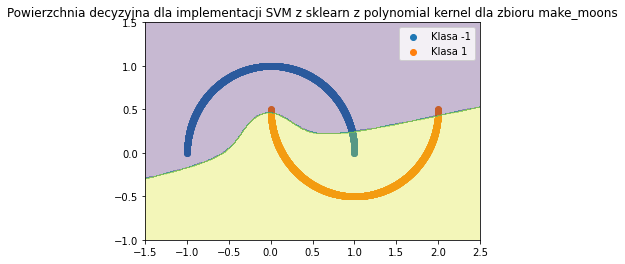

In [102]:
plt.scatter(x2[:,0][y2==-1], x2[:,1][y2==-1], label='Klasa -1')
plt.scatter(x2[:,0][y2==1], x2[:,1][y2==1], label='Klasa 1')
plt.legend()
plt.contourf(X, Y, Z_poly_m_s, alpha=0.3)
plt.title('Powierzchnia decyzyjna dla implementacji SVM z sklearn z polynomial kernel dla zbioru make_moons')
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.show()

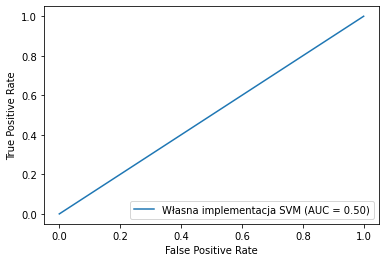

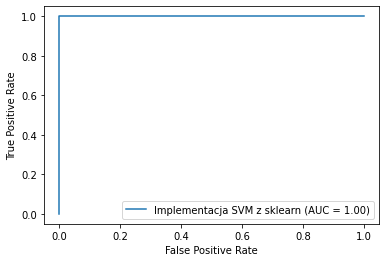

In [103]:
y_roc_i = poly_svm_m.predict_values(x2[50:100])
y_roc_s = svm_poly_sk_m.decision_function(x2[50:100])

fpr_i, tpr_i, tresholds_i = roc_curve(y2[50:100], y_roc_i)
fpr_s, tpr_s, tresholds_s = roc_curve(y2[50:100], y_roc_s)
auc_i = auc(fpr_i, tpr_i)
auc_s = auc(fpr_s, tpr_s)

display_i = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i, roc_auc=auc_i, estimator_name='Własna implementacja SVM')
display_s = RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=auc_s, estimator_name='Implementacja SVM z sklearn')
display_i.plot()
display_s.plot()
plt.show()

In [104]:
print('Własna implementacja:')
print('accuracy', accuracy_score(y2[50:100], pred_poly_m))
print('sensitivity', recall_score(y2[50:100], pred_poly_m))
print('specificity', cm_poly_m[0][0]/(cm_poly_m[0][0]+cm_poly_m[0][1]))
print()
print('Sklearn:')
print('accuracy', accuracy_score(y2[50:100], pred_poly_sk_m))
print('sensitivity', recall_score(y2[50:100], pred_poly_sk_m))
print('specificity', cm_poly_sk_m[0][0]/(cm_poly_sk_m[0][0]+cm_poly_sk_m[0][1]))

Własna implementacja:
accuracy 0.86
sensitivity 0.7407407407407407
specificity 1.0

Sklearn:
accuracy 1.0
sensitivity 1.0
specificity 1.0


Implementacja z sklearn poradziła sobie znacznie lepiej na tym zbiorze.

## Analiza zbioru SDSS17

- uzupełnić brakujące wartości

- usunąć nieistotne kolumny

- macierz korelacji

- normalizacja wartości

In [ ]:
data = pd.read_csv(r"star_classification.csv")

In [106]:
data_trans = data.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 'spec_obj_ID', 'fiber_ID', 'cam_col', 'MJD'])

In [107]:
data_trans['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [108]:
data_trans['tclass'] = data['class'].apply(lambda x: 1 if (x=='GALAXY' or x=='QSO') else 0)
data_trans.drop(columns='class', inplace=True)

In [109]:
data_trans.isnull().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
redshift    0
plate       0
tclass      0
dtype: int64

In [110]:
data_trans.corr()

,alpha,delta,u,g,r,i,z,redshift,plate,tclass
alpha,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,0.001667,-0.002554,0.018461
delta,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,0.031638,0.112329,0.017011
u,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.014309,0.029997,0.021321
g,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.022954,0.039443,0.022780
r,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.433241,0.655243,0.197722
i,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.492383,0.661640,0.161545
z,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.030380,0.037813,0.013206
redshift,0.001667,0.031638,0.014309,0.022954,0.433241,0.492383,0.030380,1.000000,0.388641,0.414245
plate,-0.002554,0.112329,0.029997,0.039443,0.655243,0.661640,0.037813,0.388641,1.000000,0.150934
tclass,0.018461,0.017011,0.021321,0.022780,0.197722,0.161545,0.013206,0.414245,0.150934,1.000000


In [111]:
x_train, x_test, y_train, y_test = train_test_split(data_trans.drop(columns='tclass'), data_trans['tclass'], random_state=254448, stratify=data_trans['tclass'])

In [112]:
scaler = MinMaxScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

In [113]:
parameters = {'kernel': ('rbf', 'poly'), 'C':[16,17,18,19,20]}
svm_gwiazdy = svm.SVC()
clf = GridSearchCV(svm_gwiazdy, parameters, n_jobs=-1)
clf.fit(scaled_x_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [16, 17, 18, 19, 20], 'kernel': ('rbf', 'poly')})

In [114]:
clf.best_params_

{'C': 19, 'kernel': 'poly'}

In [115]:
svm_gwiazdy = svm.SVC(kernel='poly', C=19)
svm_gwiazdy.fit(scaled_x_train, y_train)
pred_gwiazdy = svm_gwiazdy.predict(scaled_x_test)

Macierz pomyłek


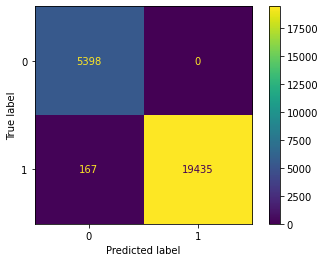

In [116]:
print('Macierz pomyłek')
cm_gwiazdy = confusion_matrix(y_test, pred_gwiazdy, labels=[0,1])
disp_gw = ConfusionMatrixDisplay(confusion_matrix=cm_gwiazdy)
disp_gw.plot()
plt.show()

Jeśli chcemy wykorzystać klasyfikator do automatycznej selekcji obiektów do obserwacji teleskopem podczas poszukiwania nowych galaktyk, powinniśmy dążyć do jak największej ilości próbek na przekątnej macierzy pomyłek ([0,0], [1,1]). Nie powinniśmy dopuścić do pojawienia się błędów FN.